In [1]:
# ! pip install wget
# ! pip install torch
# ! pip install segmentation_models_pytorch

In [2]:
!pip install tqdm

In [3]:
# Create data directory
# !mkdir -p data

# Download the dataset files
# !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz -P data/
# !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz -P data/

# Extract both archives into .data directory
# !cd data && tar -xf images.tar.gz
# !cd data &&tar -xf annotations.tar.gz

# Optional: Remove the compressed files to save space


In [4]:
import torch
import torch.nn as nn
import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


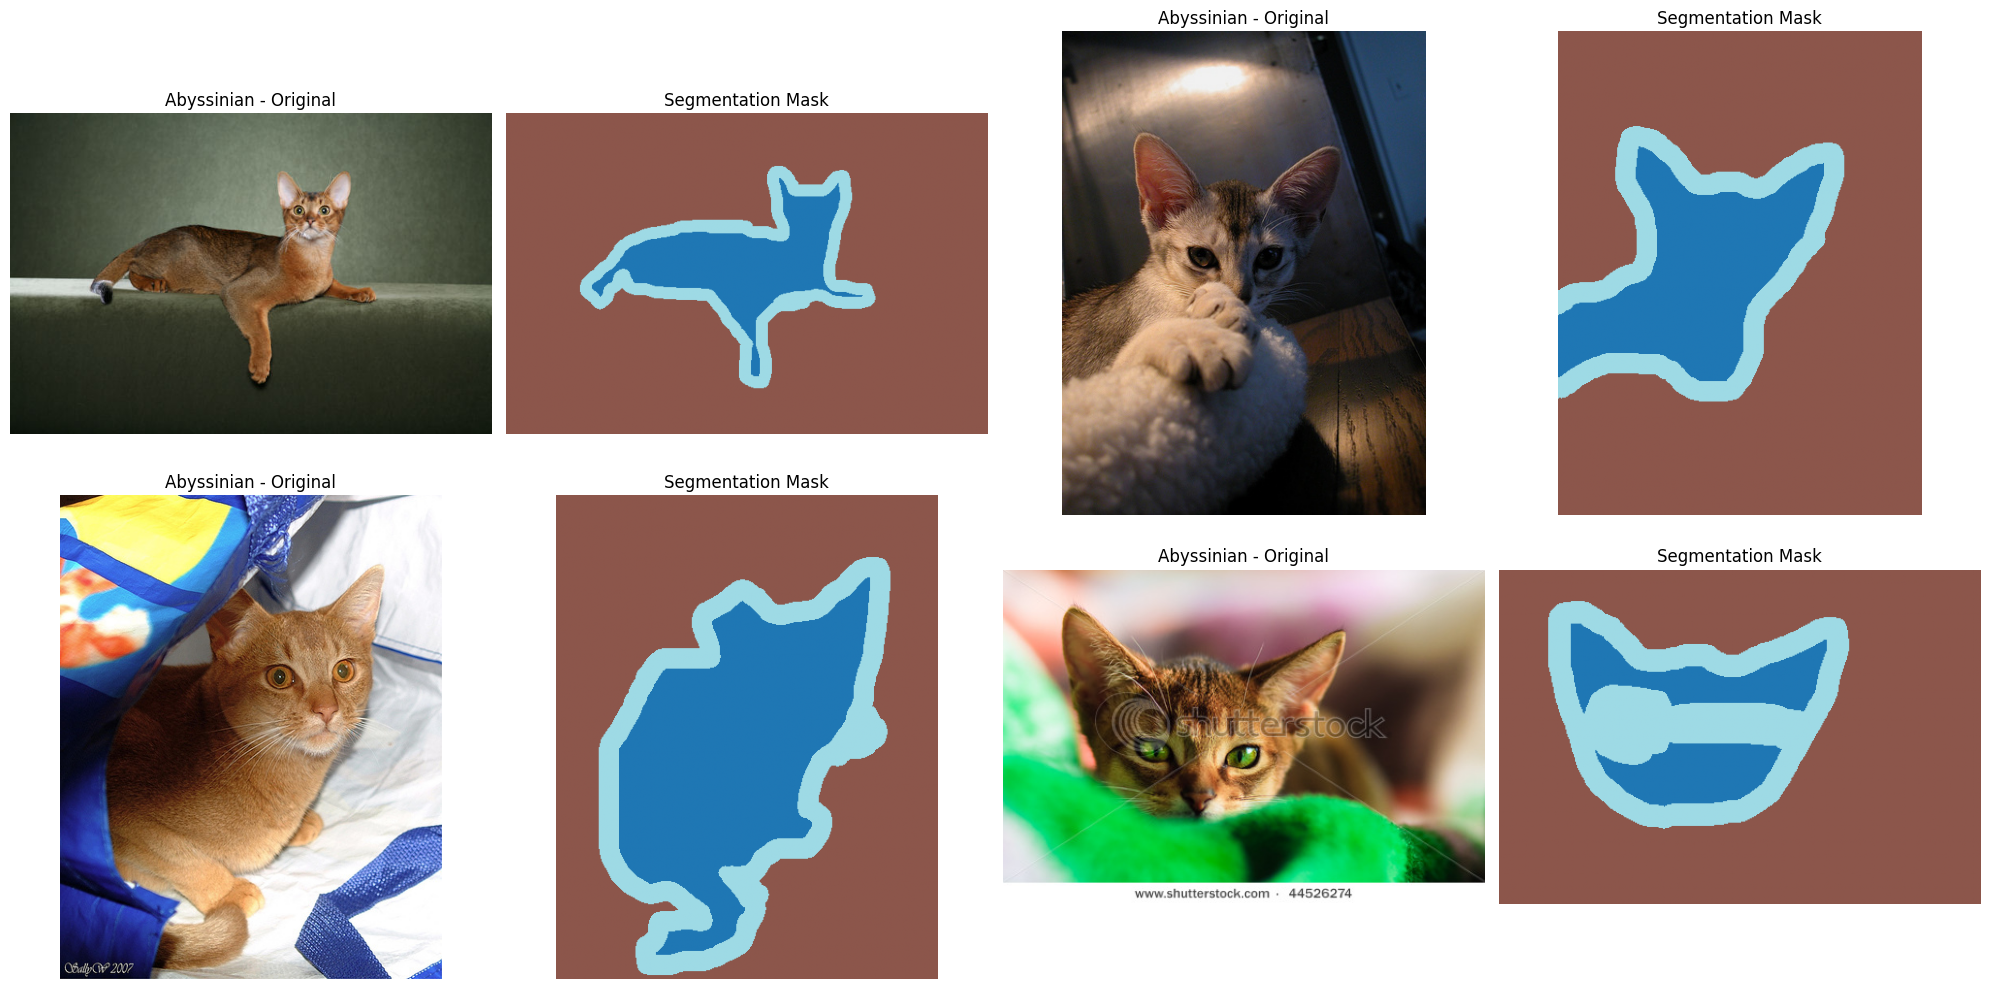


Dataset Annotations Include:
1. Species/Breed Names (37 categories)
2. Head Bounding Box (ROI)
3. Trimap Segmentation:
   - 1: Pet
   - 2: Background
   - 3: Border/Undefined


In [5]:

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
import numpy as np

# Set up the data directories
data_dir = 'data/images'
annotation_dir = 'data/annotations'  # Add annotations directory

# Get list of image files
image_files = sorted([f for f in os.listdir(data_dir) if f.endswith(('.jpg', '.png'))])[:4]

# Create a figure with 2x4 subplots (original image + trimap for each row)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Load and display first 4 images with their annotations
for idx, img_file in enumerate(image_files):
    # Load original image
    img_path = os.path.join(data_dir, img_file)
    img = Image.open(img_path)

    # Load trimap segmentation
    trimap_file = img_file.replace('.jpg', '.png')
    trimap_path = os.path.join(annotation_dir, 'trimaps', trimap_file)
    trimap = Image.open(trimap_path)

    # Plot in corresponding subplots
    row = idx // 2
    col = idx % 2 * 2  # Multiply by 2 to leave space for annotations

    # Plot original image
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(f'{img_file.split("_")[0]} - Original')

    # Plot trimap segmentation
    axes[row, col + 1].imshow(trimap, cmap='tab20')
    axes[row, col + 1].axis('off')
    axes[row, col + 1].set_title('Segmentation Mask')

plt.tight_layout()
plt.show()

# Optional: Display annotation statistics
def print_annotation_info():
    print("\nDataset Annotations Include:")
    print("1. Species/Breed Names (37 categories)")
    print("2. Head Bounding Box (ROI)")
    print("3. Trimap Segmentation:")
    print("   - 1: Pet")
    print("   - 2: Background")
    print("   - 3: Border/Undefined")

print_annotation_info()

In [6]:
# Set up dataset and dataloader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PetSegmentationDataset(Dataset):
    def __init__(self, data_dir, annotation_dir, transform):
        self.data_dir = data_dir
        self.annotation_dir = annotation_dir
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')

        # Load trimap
        trimap_file = self.image_files[idx].replace('.jpg', '.png')
        trimap_path = os.path.join(self.annotation_dir, 'trimaps', trimap_file)
        trimap = Image.open(trimap_path)


        # Apply transforms
        img = self.transform(img)
        trimap = torch.tensor(np.array(trimap.resize((256, 256))), dtype=torch.long)
        trimap[trimap == 1] = 0
        trimap[trimap == 2] = 1
        trimap[trimap == 3] = 2



        return img, trimap

In [14]:

# Visualization function
def visualize_predictions(model, dataset, num_samples=4):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for idx in range(num_samples):
        img, true_mask = dataset[idx]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))
            pred_mask = torch.argmax(pred, dim=1).squeeze().cpu()

        img = img.cpu()  # Move to CPU
        img = img * torch.tensor([0.229, 0.224, 0.225])[:, None, None] + torch.tensor([0.485, 0.456, 0.406])[:, None, None]  # Reverse normalization
        img = img.clip(0, 1)  # Clip to valid range

        # Plot original image
        axes[idx, 0].imshow(img.permute(1, 2, 0))
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')

        # Plot true mask
        axes[idx, 1].imshow(true_mask, cmap='tab20')
        axes[idx, 1].set_title('True Mask')
        axes[idx, 1].axis('off')

        # Plot predicted mask
        axes[idx, 2].imshow(pred_mask, cmap='tab20')
        axes[idx, 2].set_title('Predicted Mask')
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()


def evaluate_model_metrics(model, dataloader, device):
    """
    Evaluate model performance using various classification metrics.

    Args:
        model: PyTorch model to evaluate
        dataloader: PyTorch DataLoader containing validation/test data
        device: Device to run model on ('cuda' or 'cpu')

    Returns:
        dict: Dictionary containing computed metrics
    """
    from sklearn.metrics import accuracy_score, recall_score, jaccard_score, f1_score
    import numpy as np

    model.eval()

    # Initialize metric accumulators
    total_accuracy = 0
    total_recall = 0
    total_jaccard = 0
    total_f1 = 0
    total_samples = 0

    with torch.no_grad():
        for images, targets in tqdm.tqdm(dataloader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            targets = targets.cpu().numpy()  # Move targets to CPU

            # Calculate metrics for the batch and accumulate
            total_accuracy += accuracy_score(targets.flatten(), preds.flatten()) * len(targets)
            total_recall += recall_score(targets.flatten(), preds.flatten(), average='macro') * len(targets)
            total_jaccard += jaccard_score(targets.flatten(), preds.flatten(), average='macro') * len(targets)
            total_f1 += f1_score(targets.flatten(), preds.flatten(), average='macro') * len(targets)
            total_samples += len(targets)

    # Calculate average metrics
    metrics = {
        'accuracy': total_accuracy / total_samples,
        'recall': total_recall / total_samples,
        'jaccard': total_jaccard / total_samples,
        'f1': total_f1 / total_samples
    }

    print(f"\nModel Performance Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"Jaccard Index: {metrics['jaccard']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")

    return metrics

In [8]:

# preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
    # transforms.Lambda(preprocess_input),
])
dataset = PetSegmentationDataset(data_dir, annotation_dir, transform)

In [9]:
def load_checkpoint(model, checkpoint_path):
    """Load model from checkpoint"""
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, checkpoint['epoch'], checkpoint['best_loss']

def train_model(
    model,
    train_dataloader,
    epochs=100,
    learning_rate=3e-5,
    optimizer_name='adam',
    scheduler_name='cosine',
    checkpoint_dir='checkpoints',
    resume_from=None
):
    """Train the segmentation model with checkpointing and scheduling"""



    # Set up optimizer
    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name.lower() == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # Set up scheduler
    if scheduler_name.lower() == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    elif scheduler_name.lower() == 'reduce_on_plateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
    else:
        raise ValueError(f"Unsupported scheduler: {scheduler_name}")

    criterion = nn.CrossEntropyLoss()
    best_loss = float('inf')
    start_epoch = 0

    # Resume from checkpoint if specified
    if resume_from:
        model, start_epoch, best_loss = load_checkpoint(model, resume_from)
        print(f"Resuming from epoch {start_epoch} with best loss {best_loss:.4f}")

    # Create checkpoint directory
    os.makedirs(checkpoint_dir, exist_ok=True)

    print("\nStarting training...")
    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0

        for images, targets in train_dataloader:
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

        # Update scheduler
        if scheduler_name.lower() == 'cosine':
            scheduler.step()
        else:
            scheduler.step(epoch_loss)

        # Save checkpoint if best loss
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
                'best_loss': best_loss
            }
            torch.save(checkpoint, f"{checkpoint_dir}/best_model.pth")

        # Save periodic checkpoint
        if (epoch + 1) % 10 == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
                'best_loss': best_loss
            }
            torch.save(checkpoint, f"{checkpoint_dir}/checkpoint_epoch_{epoch+1}.pth")

    print("\nTraining complete!")
    return model

In [10]:
print("\n=== Using Segmentation Models PyTorch (SMP) for improved performance ===\n")
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 3e-5
OPTIMIZER_NAME = 'adam'
SCHEDULER_NAME = 'reduce_on_plateau'
CHECKPOINT_DIR = '/content/drive/My Drive/PetSegmentation/checkpoints'
RESUME_FROM = None
seed = 42

torch.manual_seed(seed)

# Create train/val split
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Create SMP model - Using UNet with ResNet34 encoder pre-trained on ImageNet
smp_model = smp.Unet(
    encoder_name="resnet34",        # Choose encoder, e.g. resnet34
    encoder_weights="imagenet",     # Use pre-trained weights
    in_channels=3,                  # Number of input channels (RGB)
    classes=3,                      # Number of output classes (pet, background, border)
).to(device)

train_model(
    smp_model,
    train_dataloader,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer_name=OPTIMIZER_NAME,
    scheduler_name=SCHEDULER_NAME,
    checkpoint_dir=CHECKPOINT_DIR,
    resume_from=RESUME_FROM
    )

# smp_model, smp_epoch, smp_best_loss = load_checkpoint(smp_model, '/content/drive/My Drive/PetSegmentation/checkpoints/best_model.pth')


=== Using Segmentation Models PyTorch (SMP) for improved performance ===



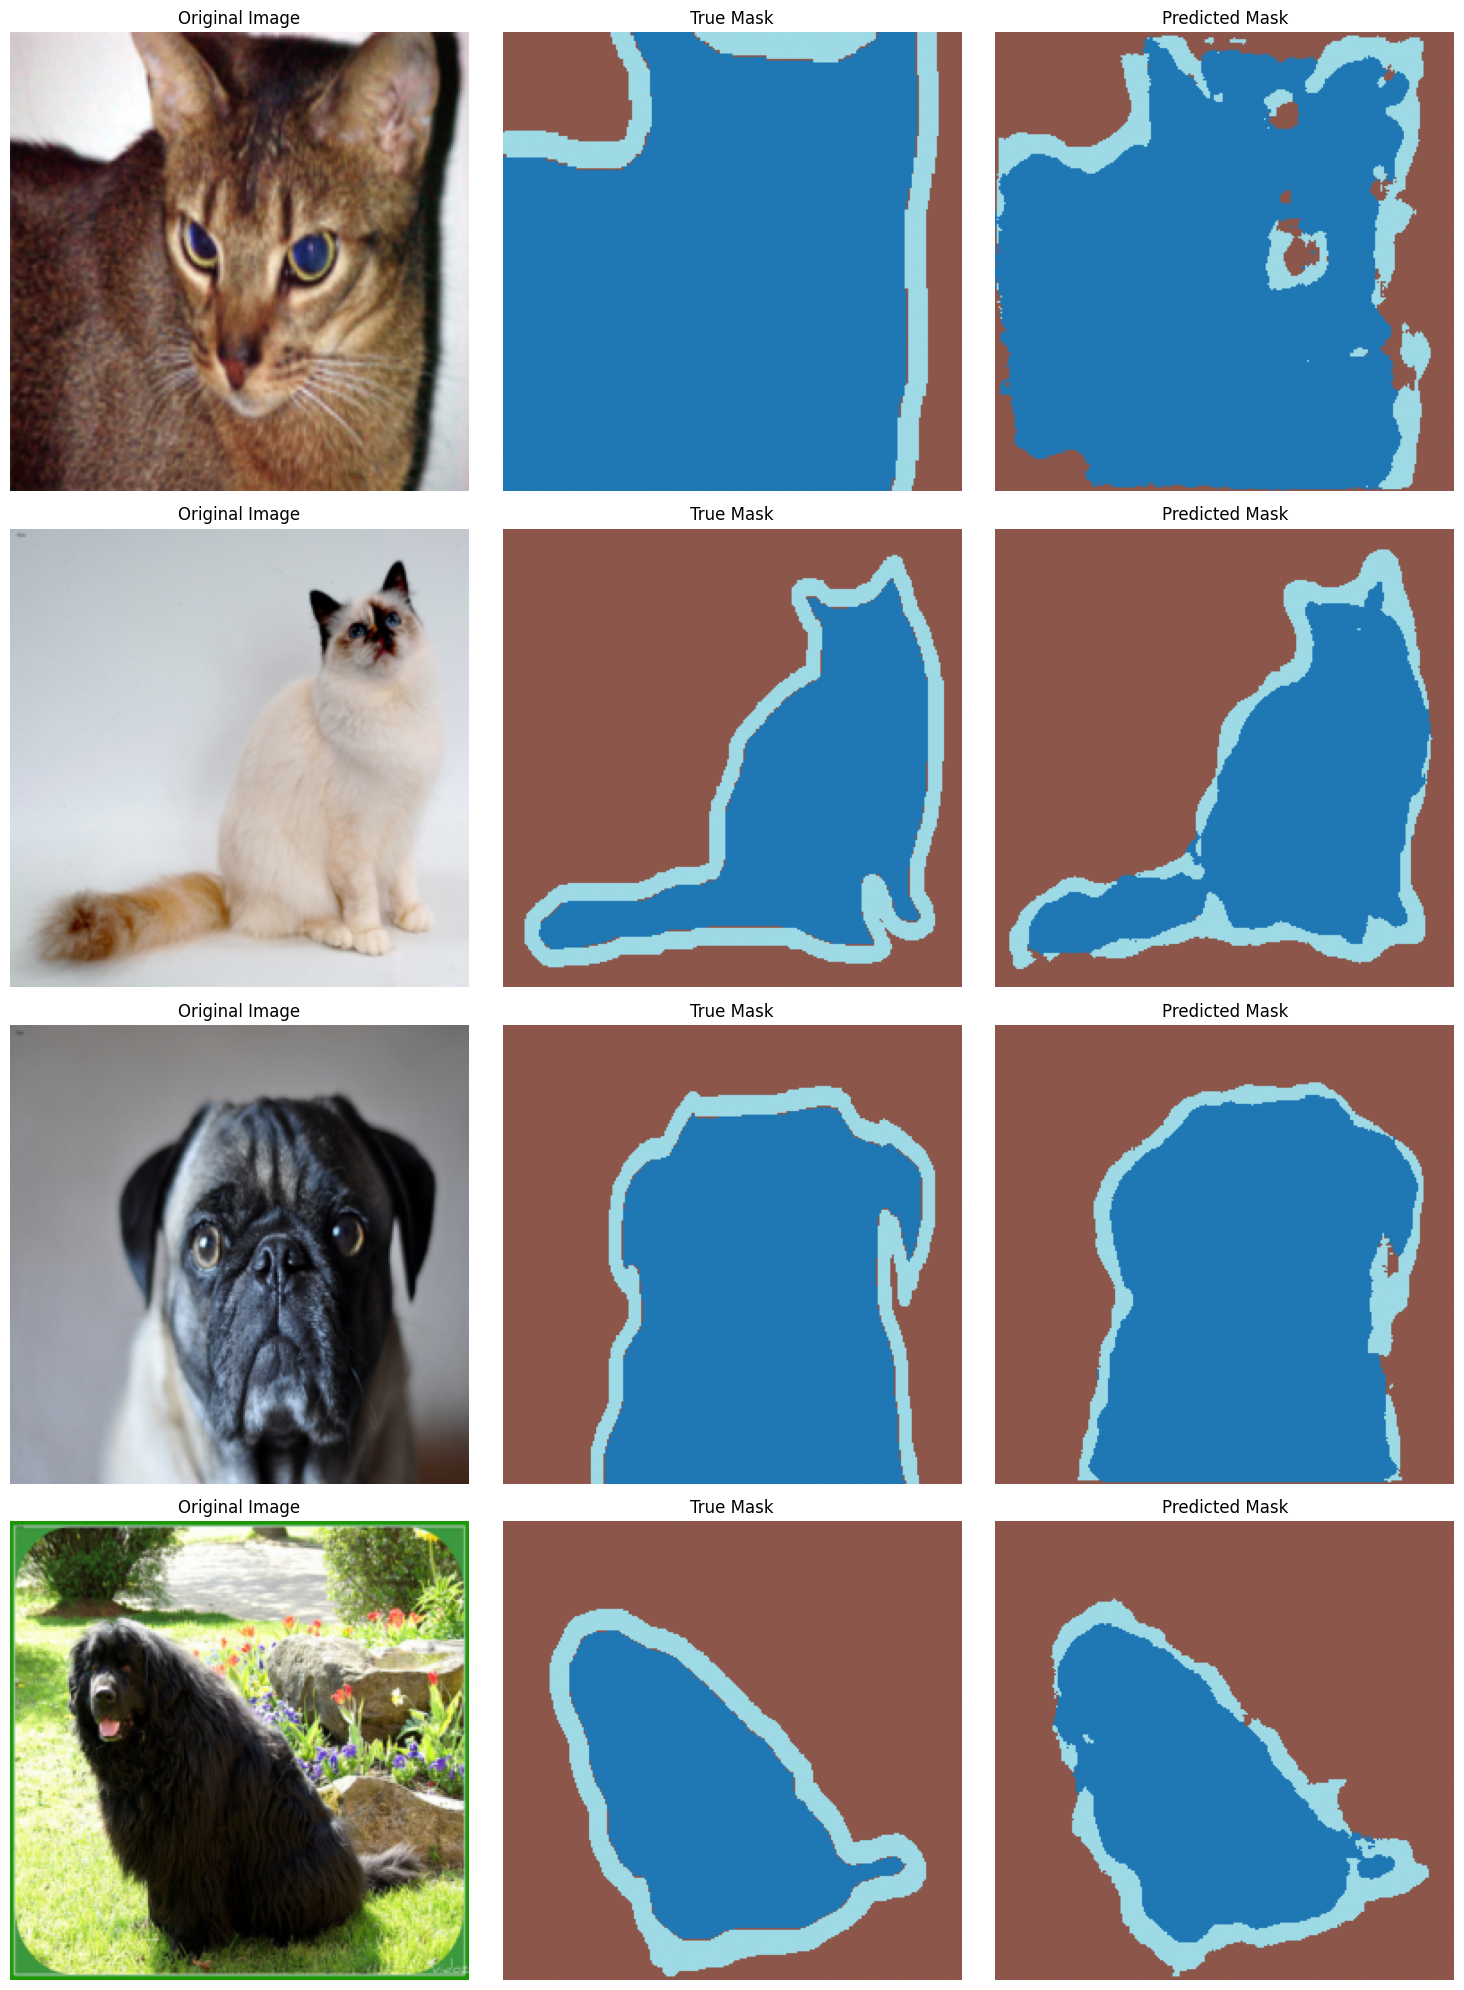

In [11]:
metrics = visualize_predictions(smp_model, (train_dataset))

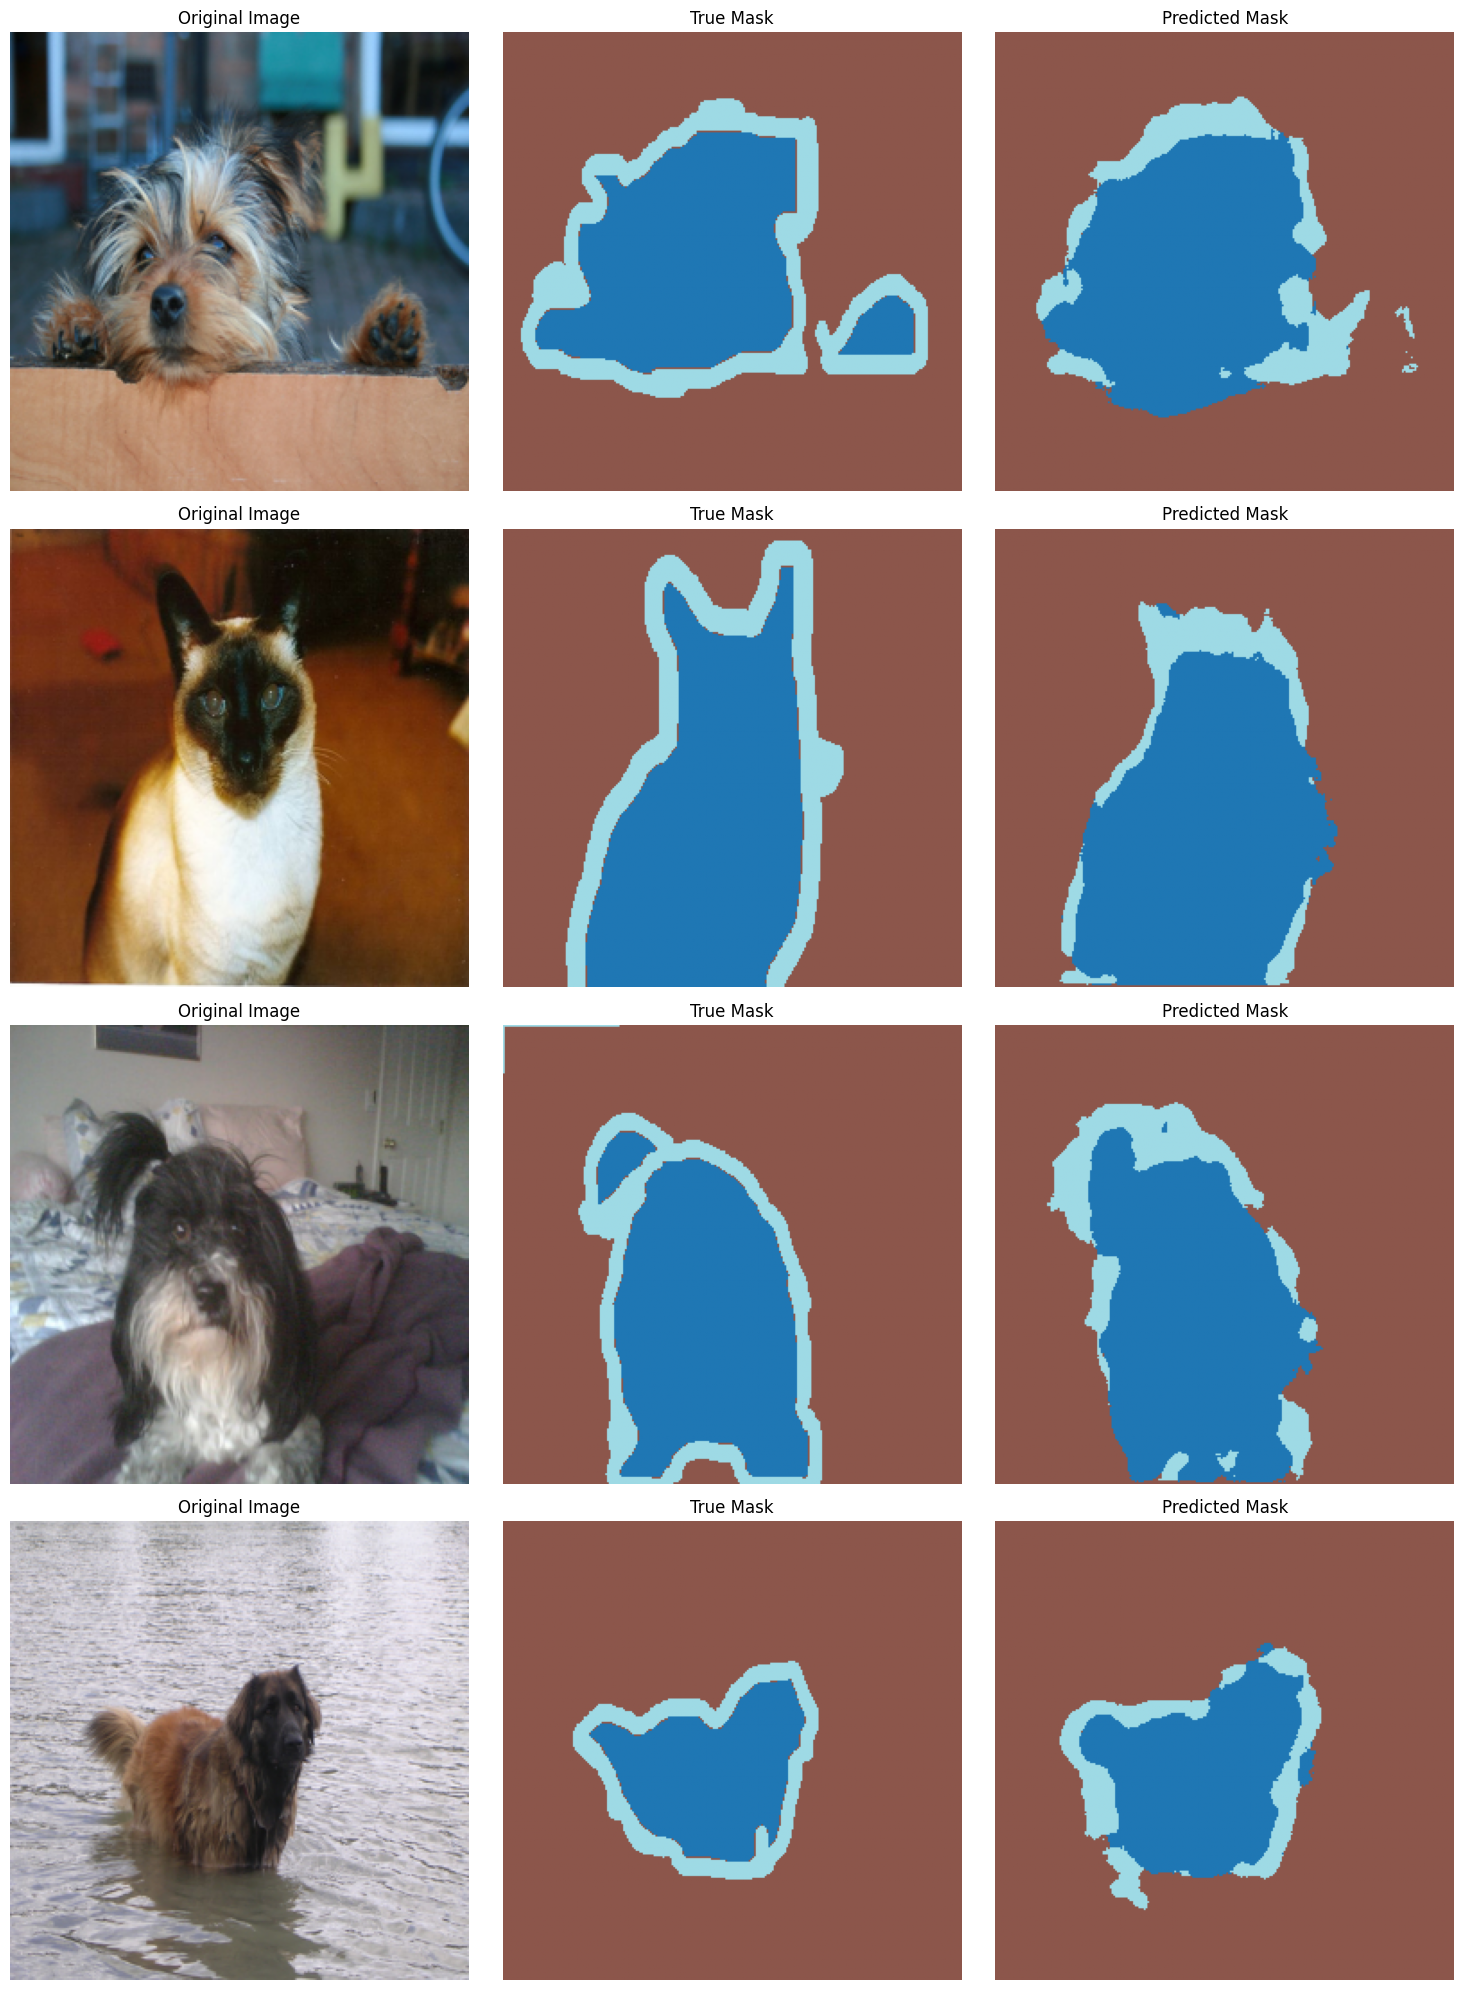

In [12]:
metrics = visualize_predictions(smp_model, (val_dataset))

In [15]:
evaluate_model_metrics(smp_model, val_dataloader, device)

100%|██████████| 227/227 [03:31<00:00,  1.08it/s]


Model Performance Metrics:
Accuracy: 0.8797
Recall: 0.7784
Jaccard Index: 0.6840
F1 Score: 0.7915


{'accuracy': 0.8796881673356384,
 'recall': 0.7784485791059502,
 'jaccard': np.float64(0.6839974784750874),
 'f1': 0.7914964594985563}

In [ ]:
evaluate_model_metrics(smp_model, train_dataloader, device)